In [30]:
# Check complete solution at
# https://github.com/dataquestio/solutions/blob/master/Mission191Solutions.ipynb
# Tons of interesting resources

import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q,conn)

def run_command(q):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(q)
        
def show_tables():
    sql = """SELECT 
                name, type 
               FROM 
                   sqlite_master 
              WHERE type IN ('table', 'view')"""
    #data = run_query(sql)
    #return data
    return (run_query)(sql)

show_tables()


,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


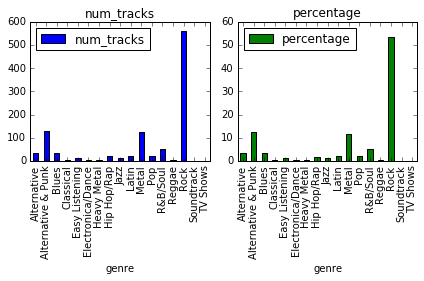

In [4]:
q = """
WITH usa_tracks_genre AS (
SELECT
    c.country,
    g.name genre,
    COUNT(*) num_tracks,
    SUM(i.total) total
FROM
    Customer c
    INNER JOIN invoice i on i.customer_id = c.customer_id
    INNER JOIN invoice_line il on il.invoice_id = i.invoice_id
    INNER JOIN track t on t.track_id = il.track_id
    INNER JOIN genre g on g.genre_id = t.genre_id
WHERE
    c.country = 'USA'
GROUP BY
    c.country,
    g.name
)
SELECT
    utg.genre,
    utg.num_tracks,
    (CAST(utg.num_tracks as float)/(SELECT SUM(num_tracks) FROM usa_tracks_genre)) * 100 percentage
FROM
    usa_tracks_genre utg


"""
df = run_query(q)
df.set_index("genre",drop=True,inplace=True)
df.plot(kind='bar', subplots=True, layout=(1,2))
plt.tight_layout()


For USA market, the top 3 genres are:
    - Rock (50%)
    - Alternative & Punk (12%)
    - Metal (10%)

The first three albums to be added to the store should be:
    - Real Tone (Punk)
    - Slim Jim Bites (Blues)
    - Meteor and the Girls (Pop)
    

In [5]:
q = """
    with sales AS (
    SELECT
        e.first_name || " " || e.last_name employee_name,
        c.country,
        c.customer_id,
        i.total 
    FROM
        Employee e
        INNER JOIN Customer c on c.support_rep_id = e.employee_id
        INNER JOIN Invoice i on i.customer_id = c.customer_id
    
    )
    SELECT
        employee_name,
        country,
        SUM(total) total_sold,
        count(distinct(customer_id)) num_customer
    FROM
        sales
    GROUP BY 
        employee_name
    ORDER BY 
        total_sold DESC,
        country       
"""
run_query(q)



,employee_name,country,total_sold,num_customer
0,Jane Peacock,United Kingdom,1731.51,21
1,Margaret Park,USA,1584.00,20
2,Steve Johnson,Canada,1393.92,18


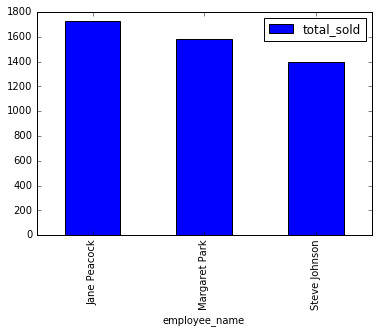

In [6]:
q = """
    SELECT
        e.first_name || " " || e.last_name employee_name,
        c.country,
        SUM(i.total) total_sold
    FROM
        Employee e
        INNER JOIN Customer c on c.support_rep_id = e.employee_id
        INNER JOIN Invoice i on i.customer_id = c.customer_id
    GROUP BY
        e.first_name || " " || e.last_name
    ORDER BY
        total_sold DESC,
        c.country
        
"""
df = run_query(q)
df.set_index("employee_name",drop=True,inplace=True)
df.plot(kind='bar')


- There are 3 markets: England, USA, and Canada
- They are very similar in size, however, England customers
buy more than Canada customers
    

In [27]:
q = """
    SELECT
        c.country,
        COUNT(DISTINCT(c.Customer_id)) num_customers,
        SUM(i.total) total_sales,
        AVG(total)avg_value_customer,
        (SELECT AVG(total) from Invoice) avg_order_value
    FROM
        Customer c
        INNER JOIN Invoice i on i.customer_id = c.customer_id
    GROUP BY
        c.country
    ORDER BY
        c.country
        
"""
run_query(q)

,country,num_customers,total_sales,avg_value_customer,avg_order_value
0,Argentina,1,39.60,7.920000,7.670081
1,Australia,1,81.18,8.118000,7.670081
2,Austria,1,69.30,7.700000,7.670081
3,Belgium,1,60.39,8.627143,7.670081
4,Brazil,5,427.68,7.011148,7.670081
5,Canada,8,535.59,7.047237,7.670081
6,Chile,1,97.02,7.463077,7.670081
7,Czech Republic,2,273.24,9.108000,7.670081
8,Denmark,1,37.62,3.762000,7.670081
9,Finland,1,79.20,7.200000,7.670081


In [24]:
q = """
with summary as (
SELECT
    c.country,
    count(distinct(c.customer_id)) num_customers,
    SUM(i.total) total_sales , 
    CAST(SUM(i.total) as float)/count(distinct(c.customer_id)) avg_per_customer,
    AVG(i.total) avg_order_value
FROM
    Customer c
    INNER JOIN Invoice i on i.customer_id = c.customer_id
GROUP BY
    c.country
ORDER BY
    total_sales DESC
),
others AS (

    SELECT
        'Others' country,
        SUM(num_customers) num_customers,
        AVG(total_sales) total_sales,
        AVG(avg_per_customer) avg_per_customer,
        AVG(avg_order_value) avg_order_value
    FROM
        summary
    WHERE
        num_customers = 1
    
),
final_output AS (

SELECT 
    country,
    num_customers,
    total_sales,
    avg_per_customer,
    avg_order_value,
    0 sort
FROM
    summary
WHERE
    num_customers != 1
UNION
SELECT
    country,
    num_customers,
    total_sales,
    avg_per_customer,
    avg_order_value,
    1 sort
FROM
    others
)
SELECT
    country,
    num_customers,
    total_sales,
    avg_per_customer,
    avg_order_value
FROM
    final_output
ORDER BY 
    total_sales DESC,
    sort
"""
run_query(q)

,country,num_customers,total_sales,avg_per_customer,avg_order_value
0,USA,13,1040.490,80.037692,7.942672
1,Canada,8,535.590,66.948750,7.047237
2,Brazil,5,427.680,85.536000,7.011148
3,France,5,389.070,77.814000,7.781400
4,Germany,4,334.620,83.655000,8.161463
5,Czech Republic,2,273.240,136.620000,9.108000
6,United Kingdom,3,245.520,81.840000,8.768571
7,Portugal,2,185.130,92.565000,6.383793
8,India,2,183.150,91.575000,8.721429
9,Others,15,72.996,72.996000,7.445071


In [ ]:
q = """
with summary as (
SELECT
    c.country,
    count(distinct(c.customer_id)) num_customers,
    SUM(i.total) total_sales , 
    CAST(SUM(i.total) as float)/count(distinct(c.customer_id)) avg_per_customer,
    AVG(i.total) avg_order_value
FROM
    Customer c
    INNER JOIN Invoice i on i.customer_id = c.customer_id
GROUP BY
    c.country
ORDER BY
    total_sales DESC
),
others AS (

    SELECT
        'Others' country,
        SUM(num_customers) num_customers,
        AVG(total_sales) total_sales,
        AVG(avg_per_customer) avg_per_customer,
        AVG(avg_order_value) avg_order_value
    FROM
        summary
    WHERE
        num_customers = 1
    
),
final_output AS (

SELECT 
    country,
    num_customers,
    total_sales,
    avg_per_customer,
    avg_order_value,
    0 sort
FROM
    summary
WHERE
    num_customers != 1
UNION
SELECT
    country,
    num_customers,
    total_sales,
    avg_per_customer,
    avg_order_value,
    1 sort
FROM
    others
)
SELECT
    country,
    num_customers,
    total_sales,
    avg_per_customer,
    avg_order_value
FROM
    final_output
ORDER BY 
    total_sales DESC,
    sort
"""
df = run_query(q)
df.set_index("country",drop=True,inplace=True)
df.plot(kind='bar', subplots=True, layout=(2,2))
plt.tight_layout()


- USA has a lot of customers but they don't buy a lot
- Czech Republic and United Kingdom have few customers, but they buy a lot.
- France and Germany have a good customer base but they don't
buy a lot. 

In [22]:
q = """
with order_album AS (
    SELECT
        i.invoice_id,
        t.album_id
    FROM
        Invoice i
        inner join Invoice_line il on il.invoice_id = i.invoice_id
        inner join track t on t.track_id = il.track_id
    GROUP BY
        i.invoice_id,
        t.album_id  
),
all_orders as (
    SELECT
        *,
        CASE 
            WHEN 
            (
            SELECT track_Id FROM track WHERE album_id = oa.album_id
            except
            SELECT track_id from Invoice_line 
            where invoice_id = oa.invoice_Id)
            IS NULL 
            AND
            (
            SELECT track_Id FROM track WHERE album_id = oa.album_id
            except
            SELECT track_id from Invoice_line 
            where invoice_id = oa.invoice_Id)
        IS NULL 

        THEN 1 ELSE 0 END IsFullAlbum
    FROM
        order_album oa 
),
full_album AS (
    SELECT 
        DISTINCT(invoice_id),
        IsFullAlbum
    from
        all_orders
    WHERE 
        isFullAlbum = 1
),
single_track AS (
    SELECT
        DISTINCT( ao.invoice_id),
        0 IsFullAlbum
    FROM
        all_orders  ao
        LEFT JOIN full_album fa on fa.invoice_id = ao.invoice_id
    WHERE
        ao.Isfullalbum = 0
        AND fa.invoice_id IS NULL
)
SELECT
    (SELECT COUNT(1) FROM invoice) total_invoices,
    (SELECT COUNT(1) FROM full_album) total_full_album,
    (SELECT COUNT(1) FROM single_track) total_single_track,
    CAST((SELECT COUNT(1) FROM full_album) as float) / 
    (SELECT COUNT(1) FROM invoice) as perct_full_album,
    CAST((SELECT COUNT(1) FROM single_track) as float)/
    (SELECT COUNT(1) FROM invoice) as perct_single_track

    
"""
run_query(q)

,total_invoices,total_full_album,total_single_track,perct_full_album,perct_single_track
0,614,201,413,0.327362,0.672638


- Currently 32% of sales are for full albumns. It's a big market
to lose if full albumns are not available anymore

Other business questions to answer:
- Which artist is used in the most playlists?
- How many tracks have been purchased vs not purchased?
- Is the range of tracks in the store reflective of their sales popularity?
- Do protected vs non-protected media types have an effect on popularity?